In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D
#from tensorflow.keras.callbacks import  TensorBoard
import sklearn
from sklearn.model_selection import  train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import Augmentor

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2


In [7]:
DATADIR="datasets\symbols data\original_data"


#We work with a pool of 82 different classes
CATEGORIES = ["-","!","(",")",",","+", "[","]",
              "{","}","0","1", "2","3","4","5","6","7",
              "8","9","b","d","e","f","i","j","k",
              "l","o","p","q","R","T","u","v","w","y",
              "z","A","C","G","H","M","N","S","X","alpha",
              "beta","gamma","lambda","mu","phi","theta","pi","sigma","Delta",
              "div","forall","geq","leq","infty", "forward_slash", "=",
                "int","sqrt","ascii_124","cos","sin","lt","gt","lim",
                "rightarrow","times","pm","sum","prime","log","tan",
                "neq","ldots","in","exists"]

In [8]:
IMG_SIZE=45
num_labels=len(CATEGORIES)

In [11]:

#Find the directories with particularly few original images
num_files=[]
for category in CATEGORIES:
    
    path=os.path.join(DATADIR,category)
    nfile = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    num_files.append((category,nfile))

In [80]:
#Creat the training data from the original raw data
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)#paths to each symbol directory
        class_num=CATEGORIES.index(category)
        for item in os.listdir(path):
            try:
                image_path=os.path.join(path,item)
                if os.path.isfile(image_path):
                    img_array=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                    training_data.append([img_array,class_num])

            except Exception as e:
                pass#if there are broken images
        
create_training_data()

In [13]:
X=[]
y=[]
for features, label in training_data:
    X.append(features)
    y.append(label)
    
X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE, 1)#need to conver fatures into np array
y=np.array(y) 

#normalize features data
#X=tf.keras.utils.normalize(X,axis=1)
X=X/255

In [14]:
#Defining the model for a deep learning
#Two Convolutional neural network layers with 64 nodes


model=Sequential()
model.add(Conv2D(64,(3,3),input_shape=X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
          
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(num_labels))
model.add(Activation("softmax"))
          
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

In [15]:
#Spliting the set into train and test set using scikit learn
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=1, stratify=y)

In [16]:
#Running the model over the original data, which contains many duplicates
history=model.fit(X_train,y_train,batch_size=100,epochs=3, validation_split=0.2)

Epoch 1/3
2707/2707 [==============================] - 1305s 482ms/step - loss: 0.5558 - accuracy: 0.8523 - val_loss: 0.2934 - val_accuracy: 0.9148
Epoch 2/3
2707/2707 [==============================] - 1241s 458ms/step - loss: 0.2293 - accuracy: 0.9334 - val_loss: 0.1995 - val_accuracy: 0.9403
Epoch 3/3
2707/2707 [==============================] - 1240s 458ms/step - loss: 0.1475 - accuracy: 0.9556 - val_loss: 0.1446 - val_accuracy: 0.9578


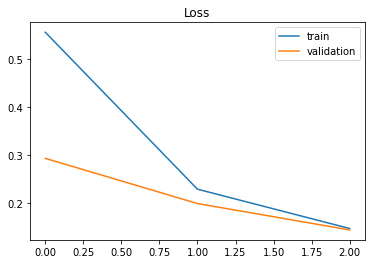

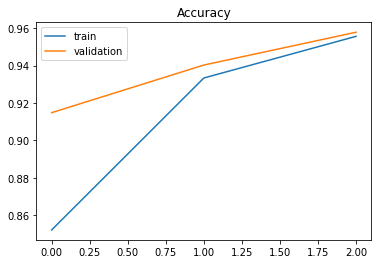

In [23]:
#Plot the train/validation loss and accuracy
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()


In [17]:
model.save('model_trained_on_original_data')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_trained_on_original_data\assets


In [26]:
#Removing the image duplicates by hashing all images and storing them into a dictionary
def duplicate_hash(image_array,hashsize=IMG_SIZE):
    #resize, so that the width is 1-pixel larger
    image_array=cv2.resize(image_array, (hashsize + 1, hashsize))
    # compute the horizontal gradient between adjacent
    diff = image_array[:, 1:] > image_array[:, :-1]
    #the hash value
    hashed= sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])
    return hashed

In [28]:
#The number of images before duplicates are removed
print(len(training_data))

375974


In [27]:
#run over the different folders with images

for category in CATEGORIES:
    hashes={}
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        #open the image into grayscale 
        image_path=os.path.join(path,img)
        img_array=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        h=duplicate_hash(img_array)
        #update the hash dictionary
        p = hashes.get(h, [])
        p.append(image_path)
        hashes[h] = p

    #Delete the repeated images:
    for (h, hashedPaths) in hashes.items():
        # check to see if there is more than one image with the same hash
        if len(hashedPaths) > 1:
                # loop over all image paths with the same hash *except*
                # for the first image in the list (since we want to keep
                # one, and only one, of the duplicate images)
                for p in hashedPaths[1:]:
                    os.remove(p)

In [32]:
#Updating the data after duplicates have been removed
training_data=[]
create_training_data()
print(len(training_data))

83493


In [33]:
X=[]
y=[]
for features, label in training_data:
    X.append(features)
    y.append(label)
    
X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE, 1)#need to conver fatures into np array
y=np.array(y) 

#normalize features data
#X=tf.keras.utils.normalize(X,axis=1)
X=X/255

In [34]:
#Spliting the set into train and test set using scikit learn
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=1, stratify=y)

In [36]:
#Running the neural network model over the smaller dataset
history2=model.fit(X_train,y_train,batch_size=100,epochs=3, validation_split=0.2)

Epoch 1/3
602/602 [==============================] - 356s 591ms/step - loss: 0.1485 - accuracy: 0.9556 - val_loss: 0.1477 - val_accuracy: 0.9539
Epoch 2/3
602/602 [==============================] - 349s 579ms/step - loss: 0.1125 - accuracy: 0.9656 - val_loss: 0.1702 - val_accuracy: 0.9441
Epoch 3/3
602/602 [==============================] - 350s 582ms/step - loss: 0.0951 - accuracy: 0.9698 - val_loss: 0.1837 - val_accuracy: 0.9424


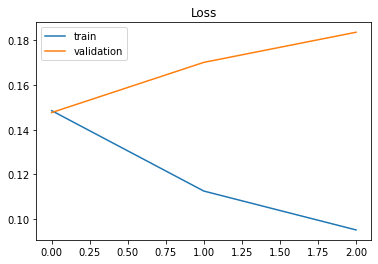

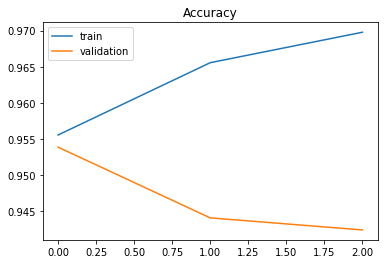

In [38]:
#Plot the train/validation loss and accuracy
plt.title('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [42]:
#The predictions are varying greately, because the data is very skewed.
#Some classes have 6000 images, while others have less than ten.
#We test the performance over the test set  

predictions=model.predict(X_test)
predictions=np.argmax(predictions, axis = 1)
#The confusion matrix
C_matrix=confusion_matrix(y_test,predictions)

report=classification_report(y_test, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       602
           1       1.00      1.00      1.00        22
           2       0.93      0.96      0.94       399
           3       0.98      0.97      0.97       398
           4       0.74      0.48      0.59        60
           5       0.96      0.99      0.98       544
           6       1.00      0.90      0.95        20
           7       0.79      0.95      0.86        20
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
          10       0.90      0.96      0.93       181
          11       0.89      0.91      0.90       633
          12       0.95      0.97      0.96       621
          13       1.00      0.97      0.98       247
          14       0.97      0.98      0.97       164
          15       0.97      0.92      0.94       101
          16       1.00      0.88      0.93        81
          17       0.94    

While the average F1 score is high it fall as low as 0.15 for some categories.

In [48]:
#Finding the categories with relatively few samples
num_files=[]
for category in CATEGORIES:
    path=os.path.join(DATADIR,category)
    nfile = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    num_files.append((category,nfile))
    
#Custom bound for what makes a category small
lower_bound=2000
sparse_categories=[]
for category in num_files:
    if category[1]<lower_bound:
        sparse_categories.append(category[0])
    


In [54]:
#Defining our data augmenting function. We use the Augmentor library Pipeline class

def image_generator(directory,new_samples=100, folder="",angle=10):
    #path to the subfolder if necessary
    path = os.path.join(DATADIR,folder)
    #start the augmentor pipeline
    image_factory=Augmentor.Pipeline(path)
    #add random rotation of max angle 10
    #with probability 0.7
    image_factory.rotate(probability=0.7, max_left_rotation=angle, max_right_rotation=angle)
    #add random elastic distortion
    #with probability 0.7
    image_factory.random_distortion(probability=0.5,grid_width=8,grid_height=8,magnitude=2)
    #add random contrast change
    #with probability 0.4
    image_factory.random_contrast(probability=0.4, min_factor=0.6, max_factor=1.0)
    image_factory.sample(new_samples)
    
    return




In [ ]:
#Using the Augmentor Pipeline class to artificially expand the dataset only for the sparse categories
#To distinguish the newly generated images, we save them in a new folder 'output', which is the default 
#directory for the Pipeline class.
new_samples=2000

for category in sparse_categories[4:]:
    image_generator(DATADIR,new_samples=new_samples,folder=category, angle=10)


In [90]:
def create_augtraining_data(categories=sparse_categories):
    for category in categories[4:]:
        path = os.path.join(DATADIR,category)#paths to each symbol dir
        path = os.path.join(path,'output')
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                training_data.append([img_array,class_num])
                
            except Exception as e:
                pass#if there are broken images
create_augtraining_data(categories=sparse_categories)

In [91]:
#sparse_categories

len(training_data)

225493

In [93]:
X=[]
y=[]
for features, label in training_data:
    X.append(features)
    y.append(label)
    
X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE, 1)#need to conver fatures into np array
y=np.array(y) 

#normalize features data
#X=tf.keras.utils.normalize(X,axis=1)
X=X/255

In [95]:
#Spliting the set into train and test set using scikit learn
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=1, stratify=y)

In [96]:
#Running the neural network model over the augmented dataset
history3=model.fit(X_train,y_train,batch_size=100,epochs=3, validation_split=0.2)

Epoch 1/3
1624/1624 [==============================] - 815s 502ms/step - loss: 0.4408 - accuracy: 0.8665 - val_loss: 0.3784 - val_accuracy: 0.8800
Epoch 2/3
1624/1624 [==============================] - 793s 488ms/step - loss: 0.2813 - accuracy: 0.9110 - val_loss: 0.3561 - val_accuracy: 0.8879
Epoch 3/3
1624/1624 [==============================] - 855s 526ms/step - loss: 0.2307 - accuracy: 0.9259 - val_loss: 0.3516 - val_accuracy: 0.8904


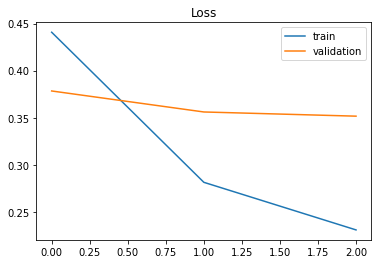

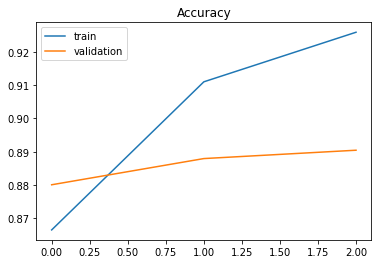

In [98]:
#Plot the train/validation loss and accuracy
plt.title('Loss')
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [99]:
#We test the performance over the test set  

predictions=model.predict(X_test)
predictions=np.argmax(predictions, axis = 1)
#The confusion matrix
C_matrix=confusion_matrix(y_test,predictions)

report=classification_report(y_test, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       602
           1       0.99      0.98      0.98       222
           2       0.94      0.96      0.95       399
           3       0.95      0.97      0.96       398
           4       0.65      0.53      0.58       260
           5       0.99      0.93      0.96       544
           6       0.84      0.94      0.89       220
           7       0.87      0.93      0.90       220
           8       0.89      0.87      0.88       207
           9       0.91      0.87      0.89       207
          10       0.85      0.75      0.80       381
          11       0.87      0.88      0.88       633
          12       0.98      0.91      0.95       621
          13       0.97      0.99      0.98       247
          14       0.86      0.88      0.87       364
          15       0.87      0.84      0.85       301
          16       0.91      0.94      0.92       281
          17       0.85    